# Semantic Segmentation with Resnet-18 backbone.
Our dataset consists of 229 greyscale x-ray images with a target area simulating a tumor and non-target background.

## Import data

In [ ]:
## check working directory of juptyer notebook

import os
os.getcwd()

'/home/comp487/CNNProject'

In [ ]:
## jupyter notebook paths

## Professor, we shared these png files with you on google drive if you want to load them and run the model yourself.

Phanthom_pth = '/home/comp487/CNNProject/Semantic_Segmentation/Phanthom_And_Template_Images/PHANTHOM_Images_PNG'
Template_pth = '/home/comp487/CNNProject/Semantic_Segmentation/Phanthom_And_Template_Images/TEMPLATE_Images_PNG'

## necessary libraries 

from PIL import Image
import glob
import numpy as np

In [ ]:
## load data from folders
  ## append img to lists as np.arrays
    
Phanthoms = []
for filename in glob.glob(Phanthom_pth + '/*.png'):
    img=Image.open(filename)
    Phanthoms.append(np.array(img))


Templates = []
for filename in glob.glob(Template_pth + '/*.png'):
    img=Image.open(filename)
    Templates.append(np.array(img))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


## set paths to each image folder

Phanthom256 = '/content/drive/MyDrive/Phantom and Template Images/Phantom_Images_PNG_256x256'
Template256 = '/content/drive/MyDrive/Phantom and Template Images/Template_Images_PNG_256x256'

Phanthom256RGB = '/content/drive/MyDrive/Phantom and Template Images/Phantom_Images_PNG_256x256_RGB'
Template256RGB = '/content/drive/MyDrive/Phantom and Template Images/Template_Images_PNG_256x256_RGB'

Phanthom768 = '/content/drive/MyDrive/Phantom and Template Images/Phantom_Images_PNG_768x1024'
Template768 = '/content/drive/MyDrive/Phantom and Template Images/Template_Images_PNG_768x1024'


## necessary libraries 

from PIL import Image
import glob
import numpy as np

Mounted at /content/drive


In [ ]:
Phanthoms = []
for filename in glob.glob(Phanthom768 + '/*.png'):
    img=Image.open(filename)
    Phanthoms.append(np.array(img))


Templates = []
for filename in glob.glob(Template768 + '/*.png'):
    img=Image.open(filename)
    Templates.append(np.array(img))

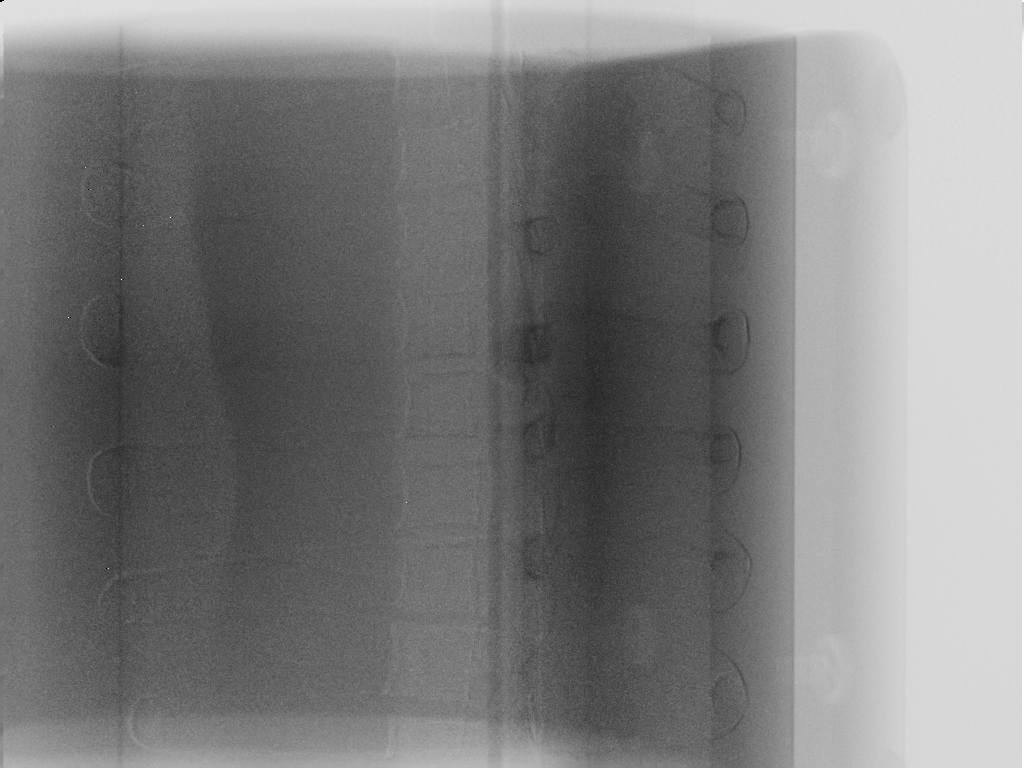

In [ ]:
## check image from array, make sure matches with Template at index
Phanthom99 = Image.fromarray(Phanthoms[99])
Phanthom99

In [ ]:
Phanthoms[99].shape

(768, 1024)

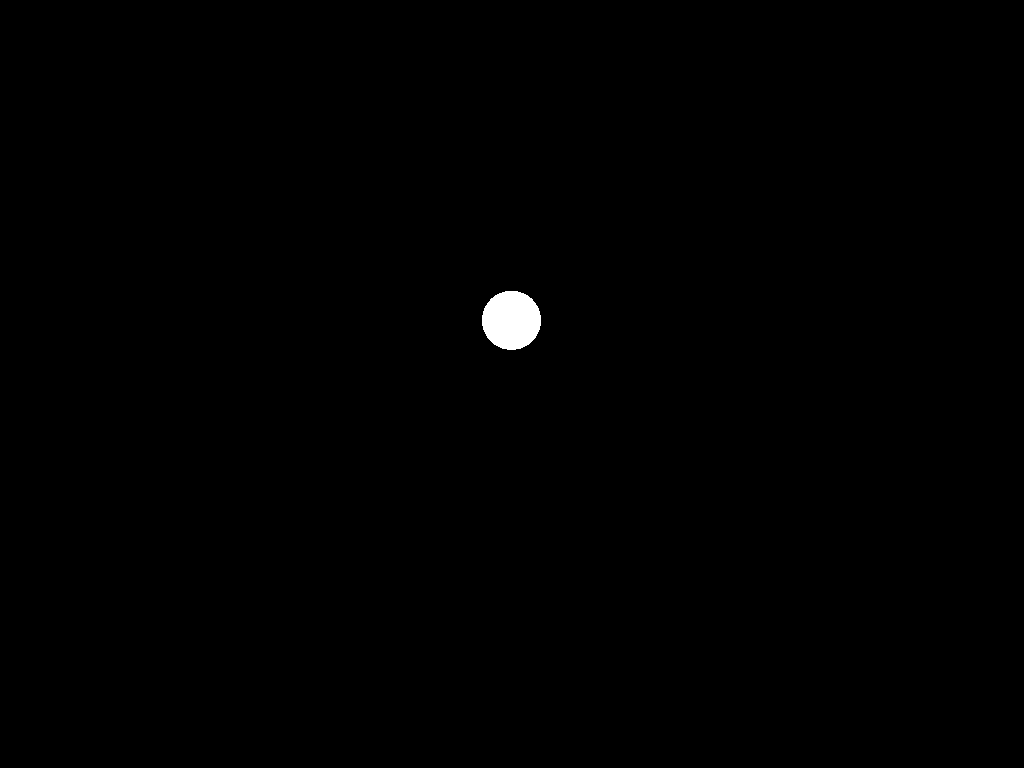

In [ ]:
## check image from array, make sure matches with Phanthom at index
Template99 = Image.fromarray(Templates[99])
Template99

In [ ]:
Templates[99].shape

(768, 1024)

# Preprocessing Data

In [ ]:

  ## normalize arrays of both phantom and template images to [0,1]
def preprocess(image, label):
    image = (image-image.min())/(image.max() - image.min())
    label = (label-label.min())/(label.max() - label.min())
    return image, label


## create empty lists for the data (phanthoms) and labels (templates)
  ## run Phanthoms and Templates through preprocessing
  ## append preprocessed data as x and y to respective lists

data, labels = [], []
for image, label in zip(Phanthoms,Templates):
    x, y = preprocess(image, label)
    data.append(x)
    labels.append(y)

In [ ]:
labels[0].min(), labels[0].max()

(0.0, 1.0)

In [ ]:
data[0].min(), data[0].max()

(0.0, 1.0)

In [ ]:
## train (.80) / test (.20) split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(data), np.array(labels), test_size=0.20, random_state=42)

In [ ]:
## check shapes 

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((183, 768, 1024), (183, 768, 1024), (46, 768, 1024), (46, 768, 1024))

In [ ]:
## in order to resize images to h x w x d, shape need to be 3D/4D
    ## ex) from (183 = number of images / arrays, 768 = h, 1024 = w) --> 
        ## (183 x 768 x 1024 x 1)
            ## 1 being 1 channel since images in greyscale

X_train = np.reshape(X_train, (-1, 768, 1024, 1))
y_train = np.reshape(y_train, (-1, 768, 1024, 1 ))
X_test = np.reshape(X_test, (-1, 768, 1024, 1))
y_test = np.reshape(y_test, (-1, 768, 1024, 1))

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((183, 768, 1024, 1),
 (183, 768, 1024, 1),
 (46, 768, 1024, 1),
 (46, 768, 1024, 1))

In [ ]:
## change to tensors

import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
## resize images to specified dimensions
    ## NOT CROPPING in order to keep location of tumors aligned with 
        ## masks from template

def resize_images(image, label):
    image = tf.image.resize(image, (768,1024))
    label = tf.image.resize(label, (768,1024))
    return image, label


train_dataset = (train_dataset
                  .map(resize_images)
                  .batch(batch_size=8, drop_remainder=True))
test_dataset = (test_dataset
                  .map(resize_images)
                  .batch(batch_size=8, drop_remainder=True))

In [ ]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(8, 768, 1024, 1), dtype=tf.float32, name=None), TensorSpec(shape=(8, 768, 1024, 1), dtype=tf.float32, name=None))>

In [ ]:
## resnet-18 model

import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


## residual block, no changes needed specific to our model

class Residual(tf.keras.Model): 
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels, padding='same', kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels, kernel_size=3, padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(
                num_channels, kernel_size=1, strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)

In [ ]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

## blocks are downsampling

b2 = ResnetBlock(32, 2, first_block=True)
b3 = ResnetBlock(64, 2)
b4 = ResnetBlock(128, 1)




In [ ]:
## going from 768 x 1024 x 1 image size, downsampling to values, upsampling to image
## blocks are downsampling

b2 = ResnetBlock(32, 2, first_block=True)
b3 = ResnetBlock(64, 2)
b4 = ResnetBlock(128, 1)

def net():
    model = tf.keras.Sequential([
        ## first 4 lines are block 1
        tf.keras.layers.Conv2D(32, kernel_size=7, strides=2, padding='same', input_shape=(768,1024,1)), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        b2, 
        b3, 
        b4, 
        # downsampling
        # upsampling
        tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid'),
        ])
    
    optimizer=tf.optimizers.Adam(learning_rate=0.001)
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=tf.metrics.BinaryAccuracy(threshold=0.3))

    return model
    

In [ ]:
model = net()

## view model structure
#tf.keras.utils.plot_model(model, show_shapes=True)
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 384, 512, 32)      1600      
                                                                 
 batch_normalization_20 (Bat  (None, 384, 512, 32)     128       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 384, 512, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 192, 256, 32)     0         
 )                                                               
                                                                 
 resnet_block_3 (ResnetBlock  (None, 192, 256, 32)     37504     
 )                                                               
                                                        

In [ ]:
## fit model onto train and test datasets. 99% validation accuracy, hooray!

history = model.fit(train_dataset, 
            epochs=10,
         validation_data=test_dataset)


Epoch 1/10
22/22 [==============================] - 1s 38ms/step - loss: 0.0046 - binary_accuracy: 0.9979 - val_loss: 0.0303 - val_binary_accuracy: 0.9963
Epoch 2/10
22/22 [==============================] - 0s 11ms/step - loss: 0.0050 - binary_accuracy: 0.9974 - val_loss: 0.0340 - val_binary_accuracy: 0.9963
Epoch 3/10
22/22 [==============================] - 0s 10ms/step - loss: 0.0045 - binary_accuracy: 0.9977 - val_loss: 0.0238 - val_binary_accuracy: 0.9963
Epoch 4/10
22/22 [==============================] - 0s 10ms/step - loss: 0.0041 - binary_accuracy: 0.9979 - val_loss: 0.0379 - val_binary_accuracy: 0.9963
Epoch 5/10
22/22 [==============================] - 0s 11ms/step - loss: 0.0038 - binary_accuracy: 0.9981 - val_loss: 0.0356 - val_binary_accuracy: 0.9963
Epoch 6/10
22/22 [==============================] - 0s 10ms/step - loss: 0.0040 - binary_accuracy: 0.9978 - val_loss: 0.0240 - val_binary_accuracy: 0.9964
Epoch 7/10
22/22 [==============================] - 0s 11ms/step - los

1/1 [==============================] - 0s 20ms/step


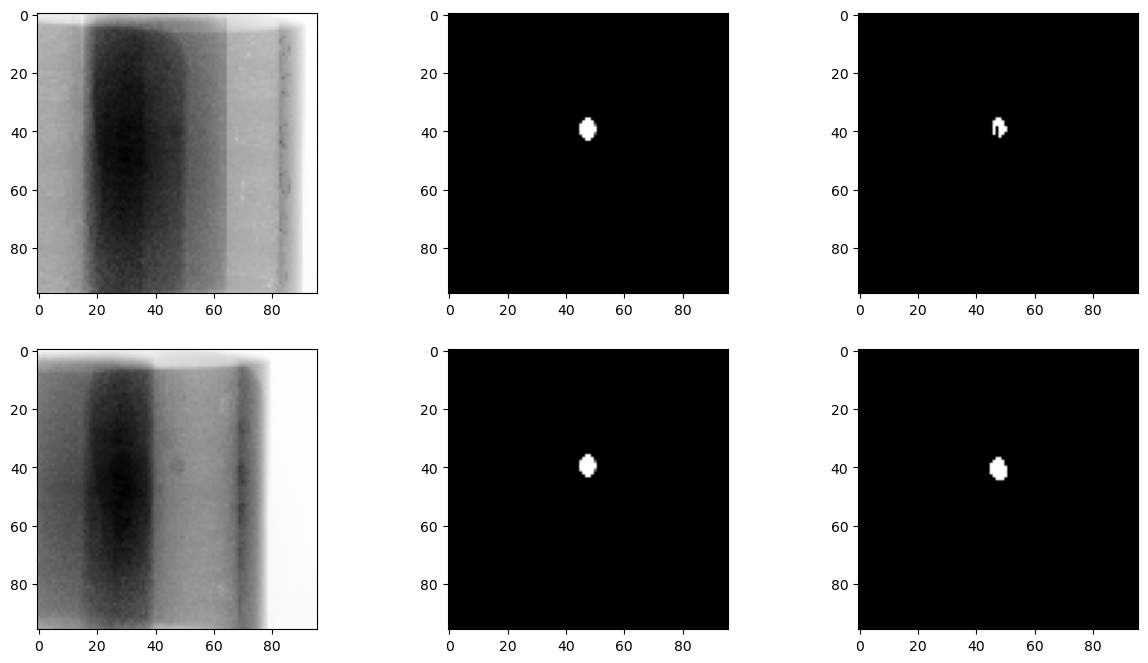

In [ ]:
# Plotting phantom images, template, and prediction.

import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(15, 8))
#ax = ax.flatten()

for i, (image, label) in enumerate(test_dataset.take(1)):
    #plottable_image = np.reshape(image, (32, 32, 3))
    for i in range(2):
        ax[i][0].imshow(image[i], cmap='gray')
        ax[i][1].imshow(label[i], cmap='gray')
        ax[i][2].imshow((model.predict(np.reshape(image[i], (1,768,1024,1))).squeeze() > 0.3) * 1, cmap='gray')